In [ ]:
import os
job_cancel_str="scancel " + os.environ['SLURM_JOBID']
os.system(job_cancel_str)

# Readining 1 Channel

In [71]:
import sys
import os
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import json
from itertools import combinations

import matplotlib.pyplot as plt

In [2]:
sys.path.append('/storage/users/g-and-n/naorko_code/code/')

In [3]:
from learning_tabular.preprocessing import load_plate_csv, list_columns
from hit_finding.metrics import *

In [4]:
cols = json.load(open('/storage/users/g-and-n/plates/columns.txt', 'r'))
chans = [c for c in cols.keys() if c not in ['GENERAL', 'MIXED']]
chans

del cols['GENERAL']
del cols['MIXED']

cols['ALL'] = sum(cols.values(), [])

## Run new SS-Analyze on 100 plates of raw1to1

In [7]:
def generate_scores(cpdf, abs_zscore=True, th_range=range(2, 21)):
    res = {}
    rep_cnt, fet_cnt = cpdf.shape

    corr = cpdf.astype('float64').T.corr(method='pearson').values
    if len(corr) == 1:
        med_corr = 1
    else:
        med_corr = np.median(list(corr[np.triu_indices(len(corr), k = 1)]))
        
    res['Med_Corr'] = med_corr
    
    cpdf_norm = cpdf * np.sqrt(rep_cnt)
    
    if abs_zscore:
        cpdf_norm = abs(cpdf_norm.T)

    for t in th_range:
        gtr_t_cnt = (cpdf_norm >= t).sum().sum()
        ss_norm = gtr_t_cnt / rep_cnt
        mas = np.sqrt((max(med_corr, 0) * ss_norm) / fet_cnt)
        res[f'SS_{t}'] = ss_norm
        res[f'MAS_{t}'] = mas
    
    return pd.Series(res)

In [8]:
raw1to1_pure_fld = '/storage/users/g-and-n/tabular_models_results/30000/results/z_scores/pure/raw1to1/'

In [17]:
raw1to1_pure_files = [os.path.join(raw1to1_pure_fld, f) for f in os.listdir('/storage/users/g-and-n/tabular_models_results/40015/channel RNA/zscores/')]

In [10]:
raw1to1_df = pd.concat([pd.read_csv(pth, index_col=[0,1,2,3]) for pth in raw1to1_pure_files])
raw1to1_df = raw1to1_df.query('Metadata_ASSAY_WELL_ROLE == "treated"').droplevel(1)

raw1to1_res = {chan: raw1to1_df[c].groupby('Metadata_broad_sample').apply(generate_scores, abs_zscore=False, th_range=[2, 6, 10, 14]).add_prefix(f'{chan}_') for chan, c in cols.items()}

In [11]:
pd.concat([*raw1to1_res.values()], axis=1).to_csv('/storage/users/g-and-n/tabular_models_results/40100/bigrun_scores.csv')

## Load results

In [12]:
raw1to1 = pd.read_csv('/storage/users/g-and-n/tabular_models_results/40100/bigrun_scores.csv', index_col=[0])
raw1to1

,AGP_Med_Corr,AGP_SS_2,AGP_MAS_2,AGP_SS_6,AGP_MAS_6,AGP_SS_10,AGP_MAS_10,AGP_SS_14,AGP_MAS_14,DNA_Med_Corr,...,RNA_MAS_14,ALL_Med_Corr,ALL_SS_2,ALL_MAS_2,ALL_SS_6,ALL_MAS_6,ALL_SS_10,ALL_MAS_10,ALL_SS_14,ALL_MAS_14
Metadata_broad_sample,,,,,,,,,,,,,,,,,,,,,
BRD-A00051892-001-05-0,1.000000,2.000000,0.152499,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,...,0.0,1.000000,4.000000,0.098295,0.000000,0.000000,0.0,0.0,0.0,0.0
BRD-A00100033-001-04-8,1.000000,4.000000,0.215666,3.0,0.186772,0.0,0.0,0.0,0.0,1.000000,...,0.0,1.000000,48.000000,0.340503,7.000000,0.130032,0.0,0.0,0.0,0.0
BRD-A00214921-001-04-2,0.169068,2.000000,0.062704,0.0,0.000000,0.0,0.0,0.0,0.0,0.677428,...,0.0,0.220874,6.500000,0.058888,0.000000,0.000000,0.0,0.0,0.0,0.0
BRD-A00267231-001-01-1,1.000000,4.000000,0.215666,3.0,0.186772,0.0,0.0,0.0,0.0,1.000000,...,0.0,1.000000,49.000000,0.344031,3.000000,0.085126,0.0,0.0,0.0,0.0
BRD-A00327403-103-01-9,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,...,0.0,1.000000,7.000000,0.130032,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BRD-M95763088-001-01-5,1.000000,7.000000,0.285299,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,...,0.0,1.000000,49.000000,0.344031,2.000000,0.069505,0.0,0.0,0.0,0.0
BRD-M97057852-001-01-4,0.117917,8.000000,0.104733,0.0,0.000000,0.0,0.0,0.0,0.0,0.256509,...,0.0,0.139510,32.666667,0.104919,0.333333,0.010598,0.0,0.0,0.0,0.0
BRD-M97109212-001-01-8,1.000000,8.000000,0.304997,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,...,0.0,1.000000,45.000000,0.329690,4.000000,0.098295,0.0,0.0,0.0,0.0


# Analyze Complementary

In [56]:
def enter_bucket_wrapper(t, th, chan, method_a = 'map',method_b = 'raw1to1'):
    def enter_bucket(sr):
        res = 0
        if sr[f'SS_{t}'] > th:
            res += 1
        if sr[f'{chan}_SS_{t}'] > th:
            res += 10

        if res == 1:
            return method_a
        if res == 10:
            return method_b
        if res == 11:
            return 'both'

        return 'none'
    
    return enter_bucket

In [68]:
def plot_complementary(res, chan, title):
    nrow = 1
    ncol = 4
    ylims = [10000, 1200, 700, 550]
    d={'xlabel':"", 'ylabel':"Amount of Hits"}

    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*8,nrow*5), subplot_kw=d, facecolor='white')
    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    fig.suptitle(f'Distributions of hits - ({title}) ->{chan}', fontsize = 32, y = 1)
    ts = [2,6,10,14]

    for i, t in enumerate(ts):
        # i=t-2
        counts = pd.concat({f'{th:.1f}': res.apply(enter_bucket_wrapper(t, th * len(cols[chan]), chan), axis=1).value_counts() for th in np.arange(0, 1.01, 0.1)}, axis=1)

        labels = counts.columns
        width = 0.55      # the width of the bars: can also be len(x) sequence


        r1=ax[i].bar(labels, counts.loc['map'], width, label='map')
        r2=ax[i].bar(labels, counts.loc['both'], width, bottom=counts.loc['map'], label='both')
        r3=ax[i].bar(labels, counts.loc['raw1to1'], width, bottom=counts.loc['map']+counts.loc['both'], label='raw1to1')
        # ax[i//ncol,i%ncol].bar_label(r1, padding=3)
        ax[i].bar_label(r1,label_type='center')
        ax[i].bar_label(r2,label_type='center')
        ax[i].bar_label(r3,label_type='center',padding=3)

        # ax[i//ncol,i%ncol].set_yscale('symlog', base=10)
        ax[i].set_xlim([1.5,6.5])
        ax[i].set_ylim([0,ylims[i]])
        ax[i].set_ylabel('Amount of Hits')
        ax[i].set_title(f'Hits Distribution - Norm-SS({t})', fontsize = 24)
        ax[i].legend()

    # fig.tight_layout()
    fig.tight_layout()
    # _ = fig.savefig(f'/sise/assafzar-group/g-and-n/tabular_models_results/30000/results/z_scores/ss_mas/plots/histogram-stacked-all-thersholds-no-abs.png', format='png')
    plt.show()
    # counts.head()

In [58]:
glob(f'/storage/users/g-and-n/tabular_models_results/400*{i}/*/')

['/storage/users/g-and-n/tabular_models_results/40033/channel ER/',
 '/storage/users/g-and-n/tabular_models_results/40023/channel ER/',
 '/storage/users/g-and-n/tabular_models_results/40013/channel ER/',
 '/storage/users/g-and-n/tabular_models_results/40043/channel ER/']

In [67]:
i_slice = int(os.path.dirname(os.path.dirname(cur_fld))[-2])

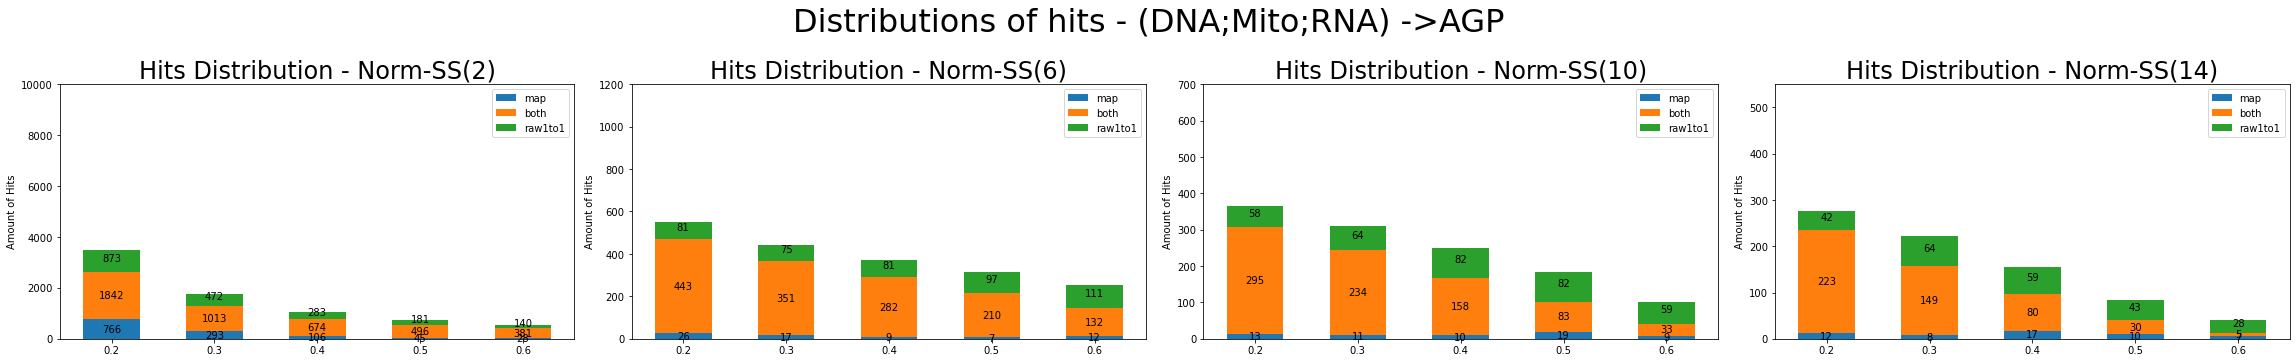

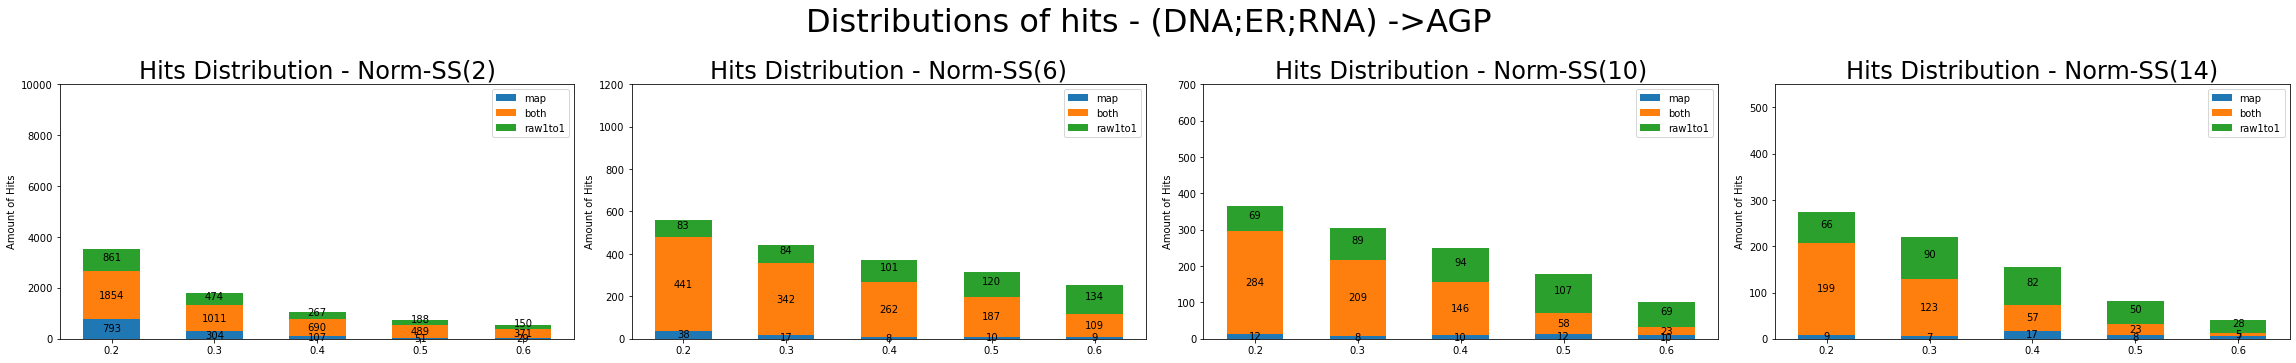

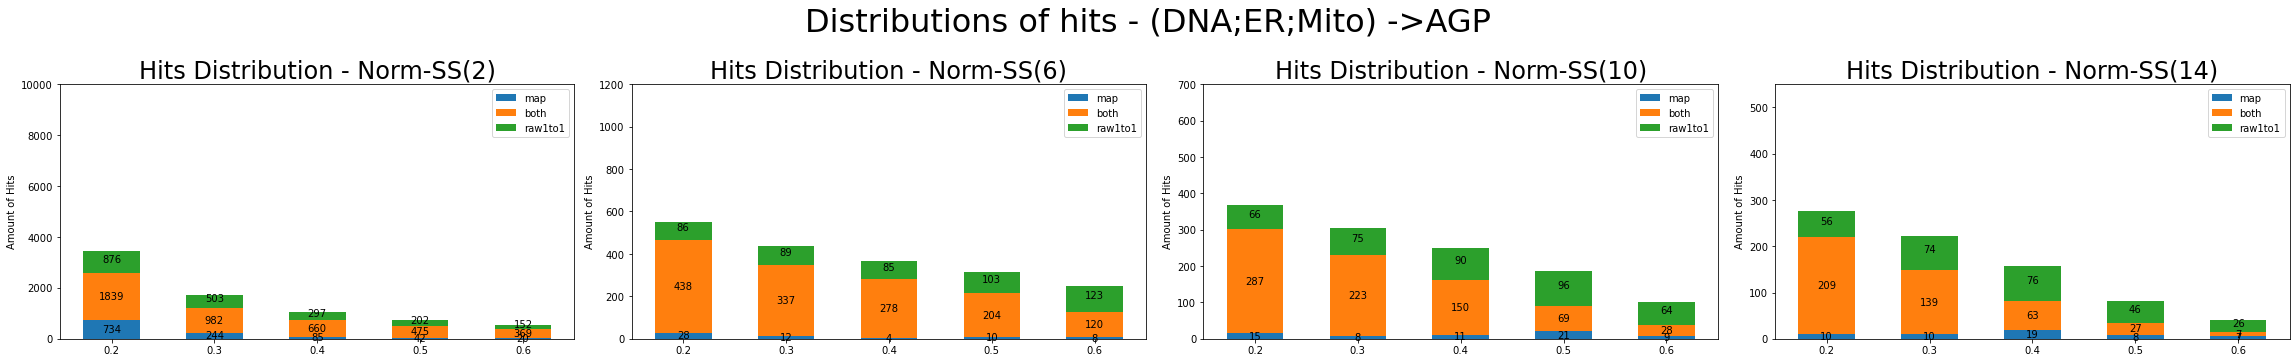

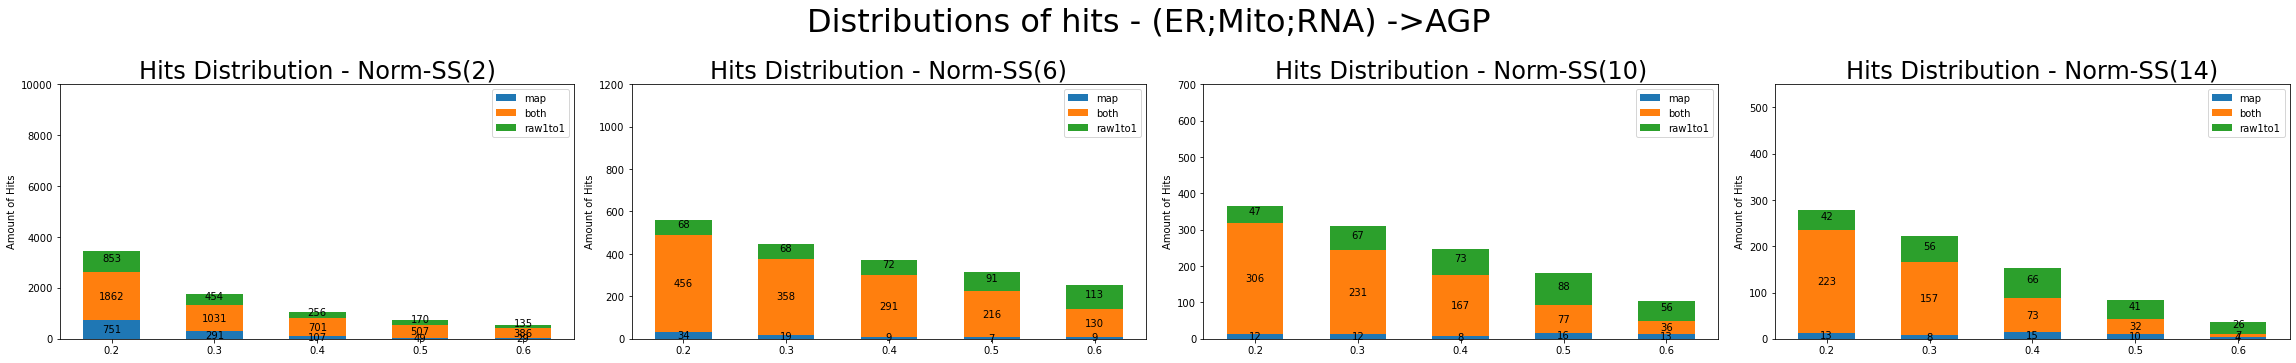

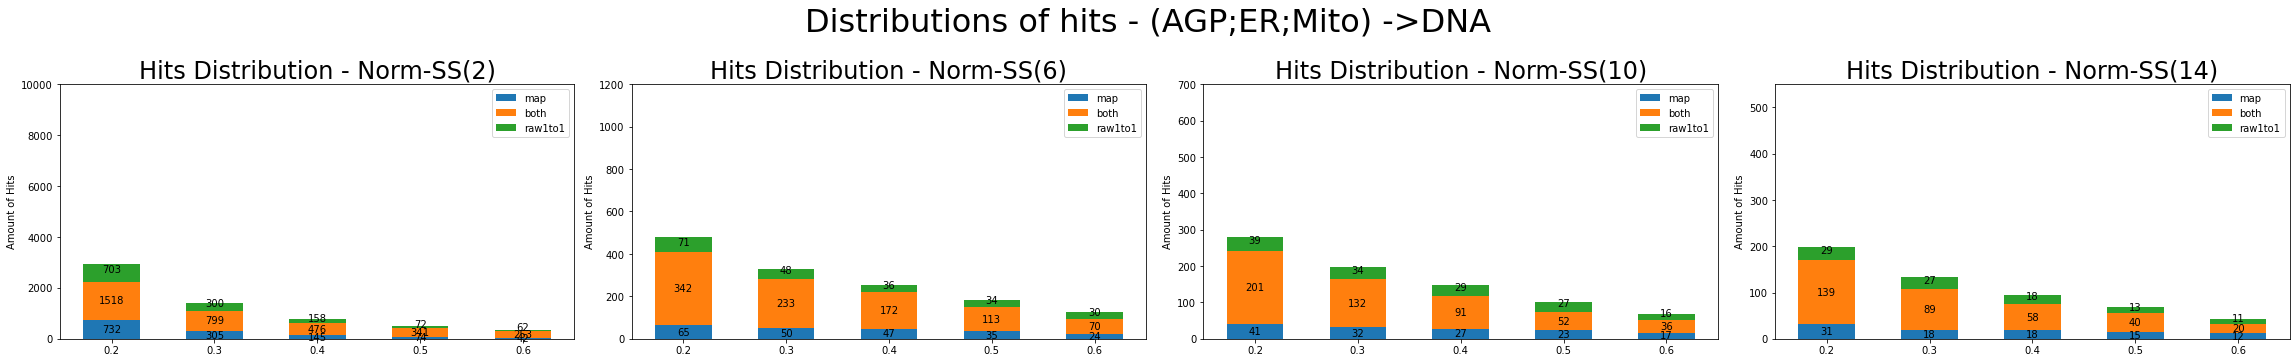

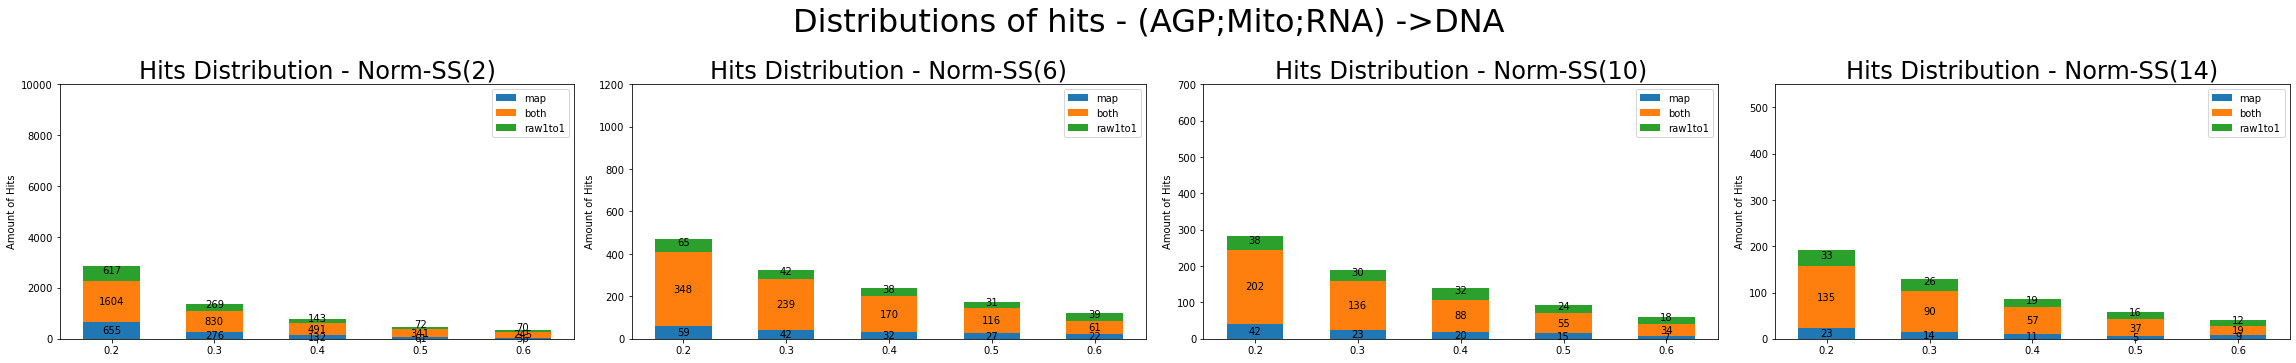

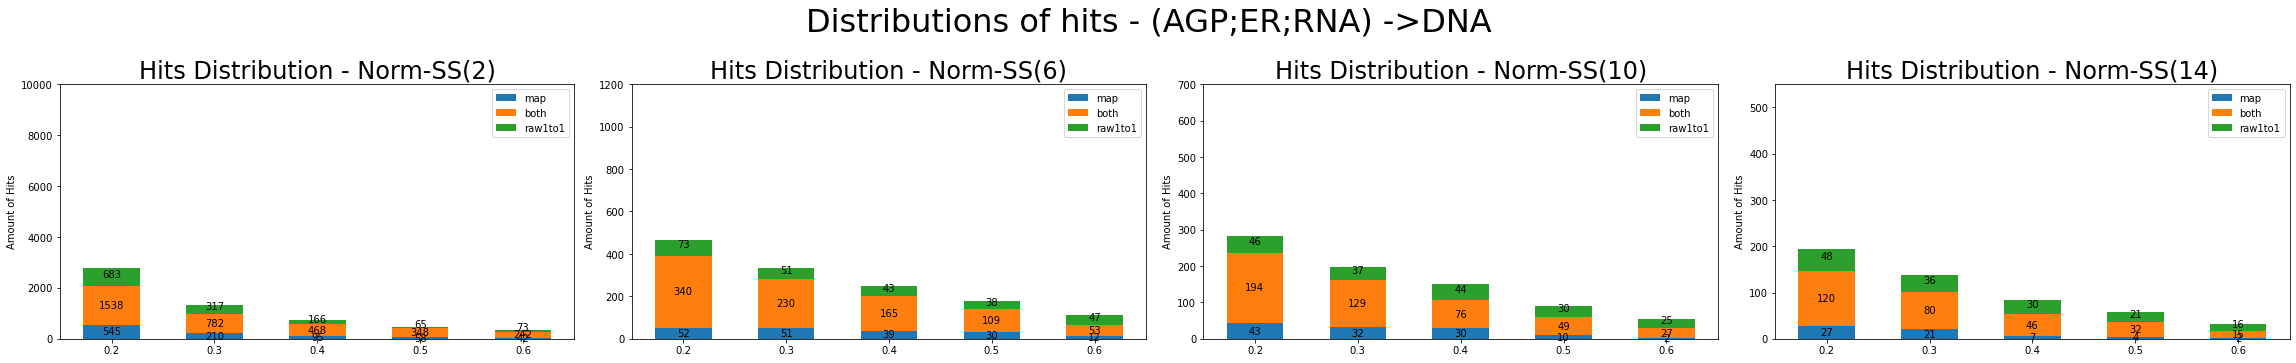

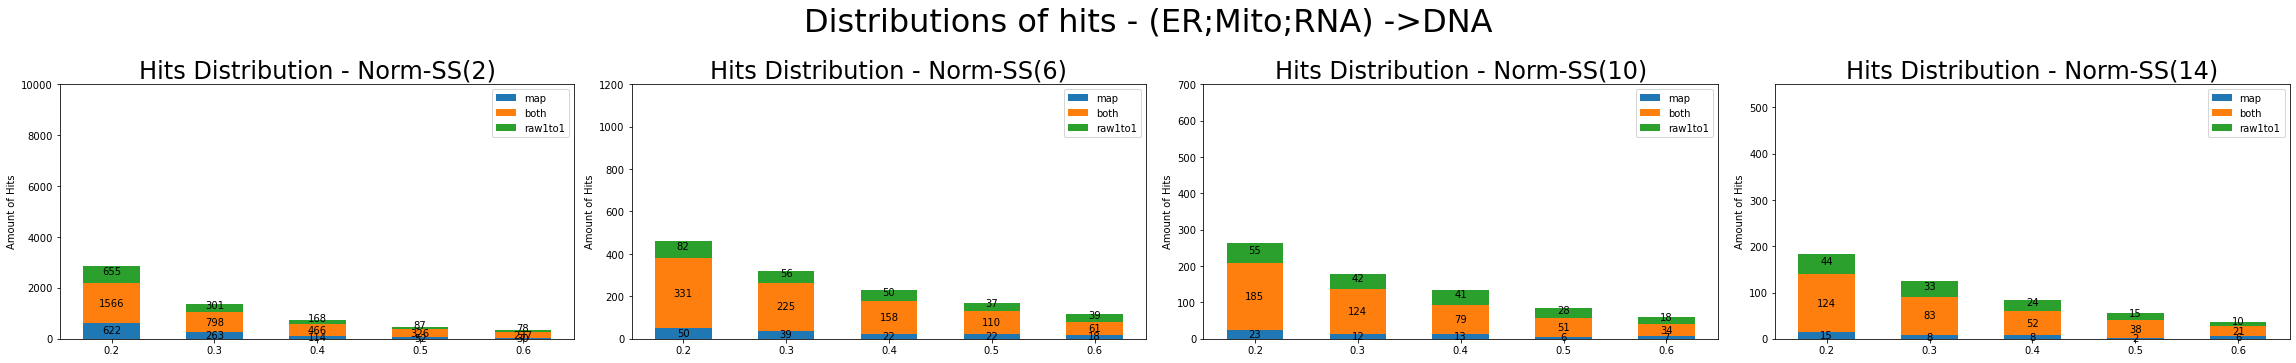

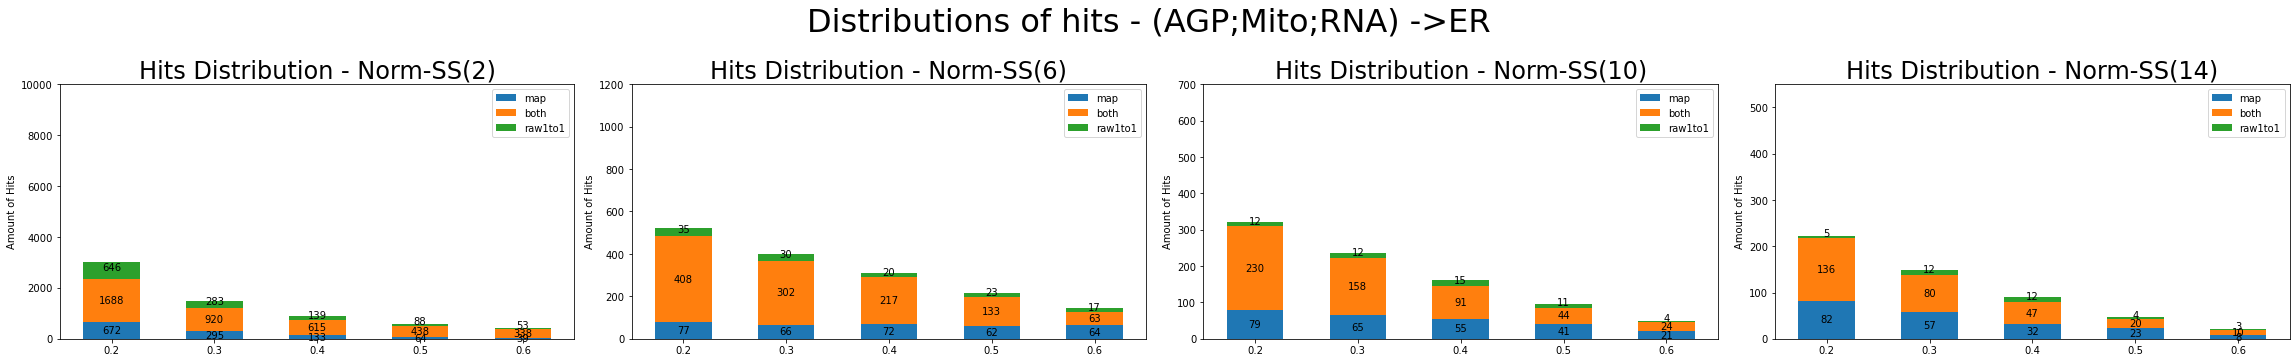

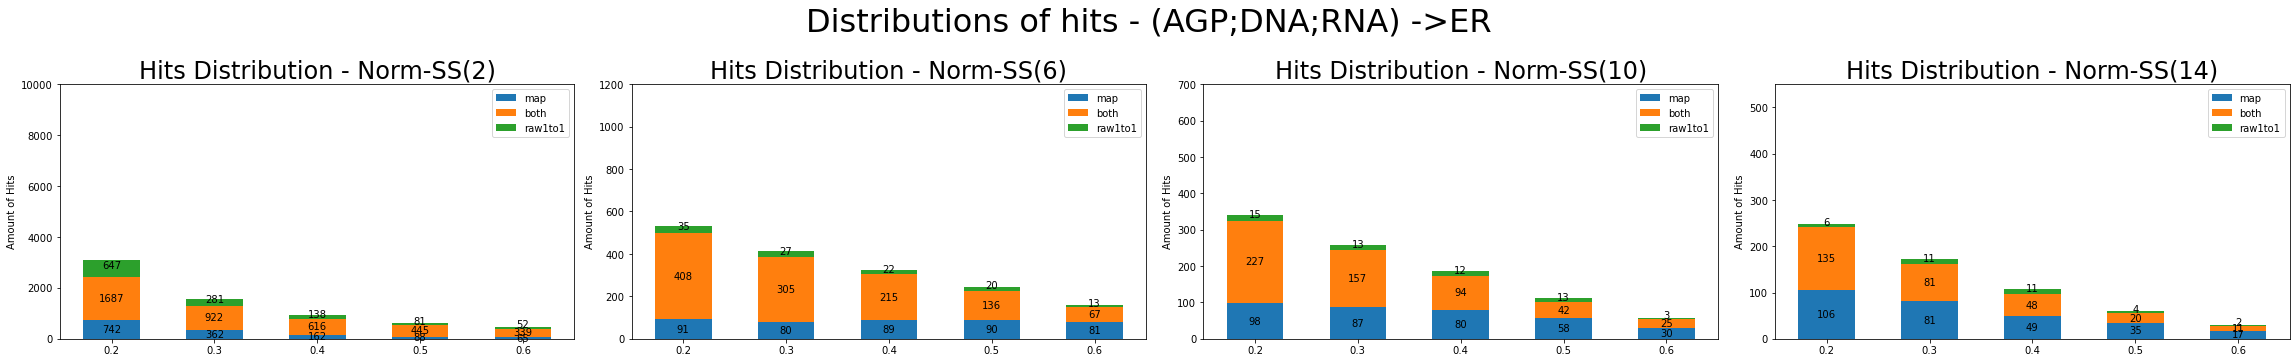

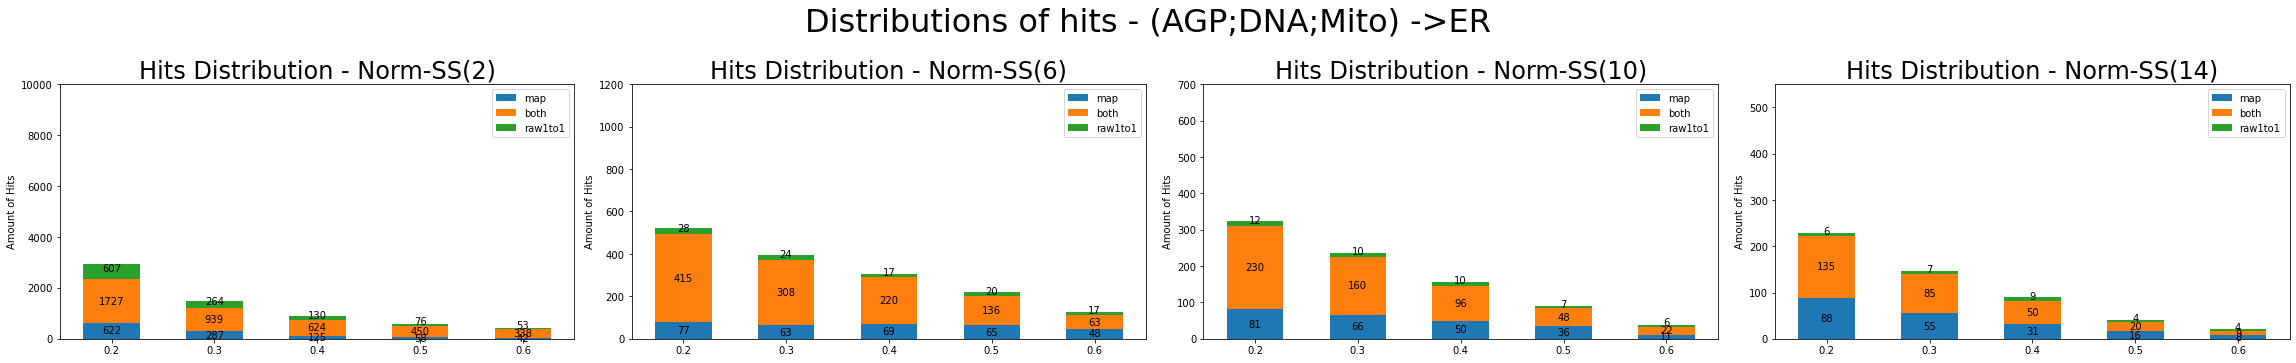

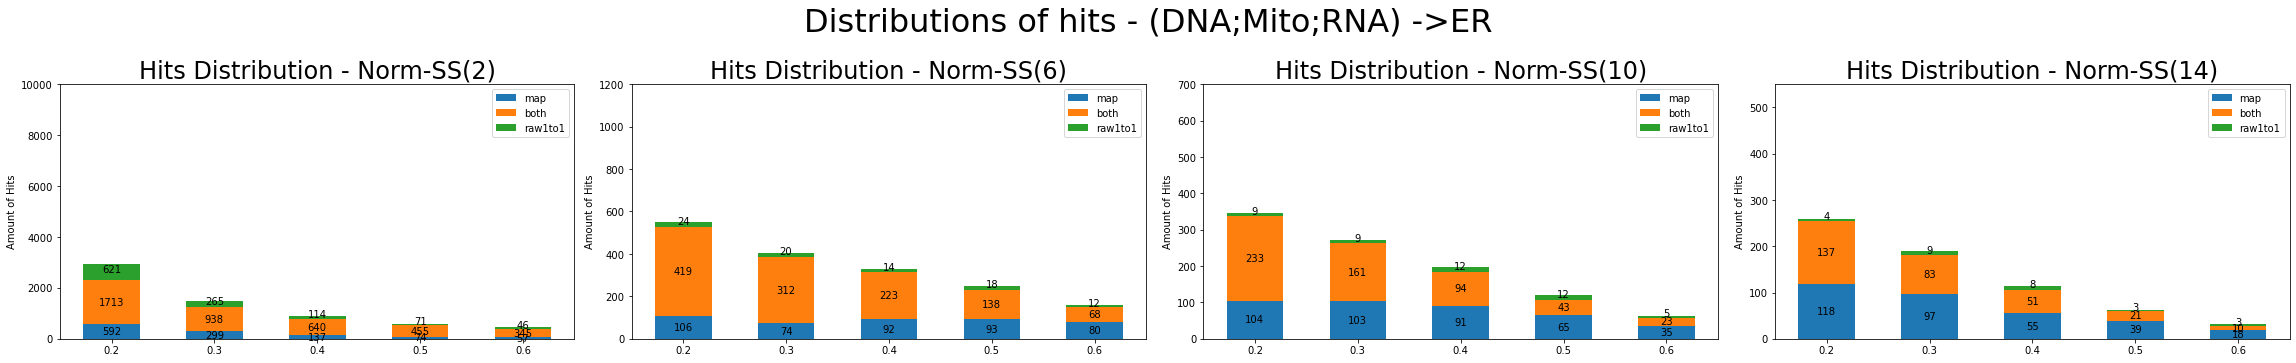

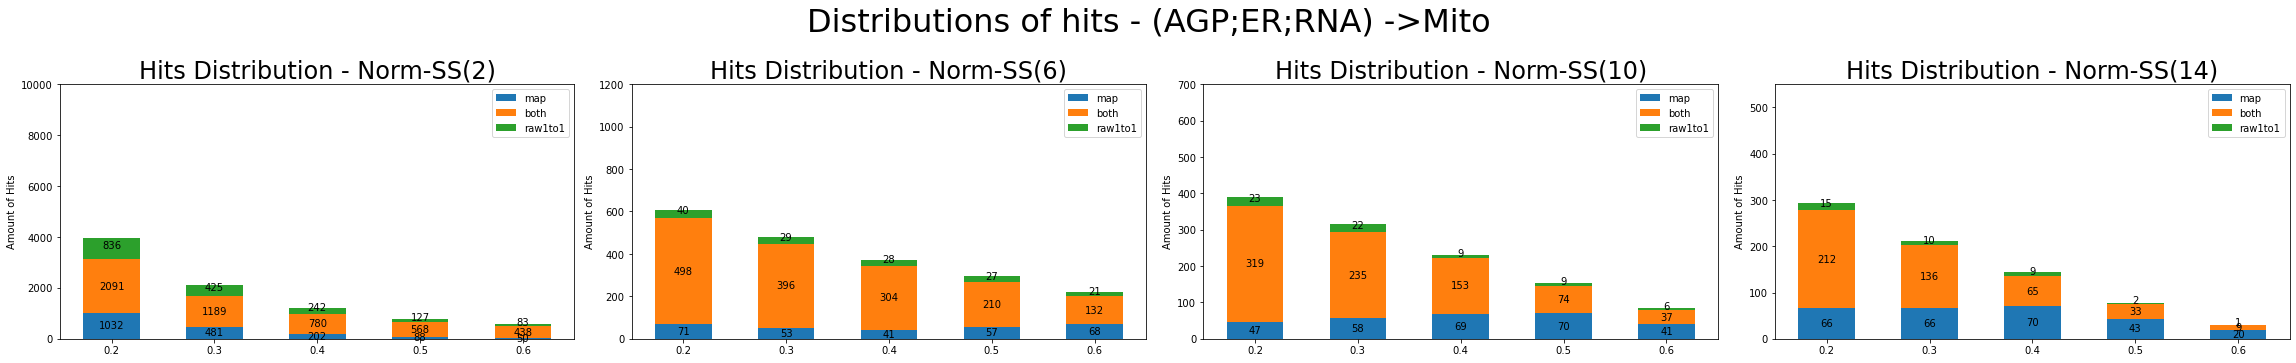

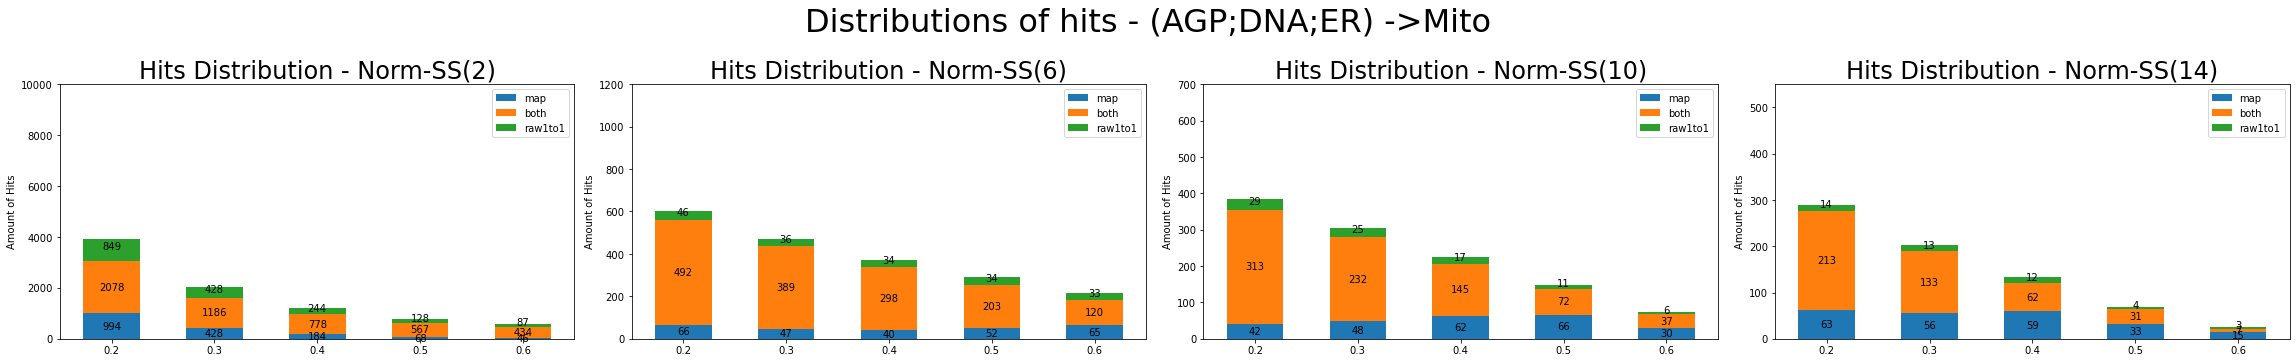

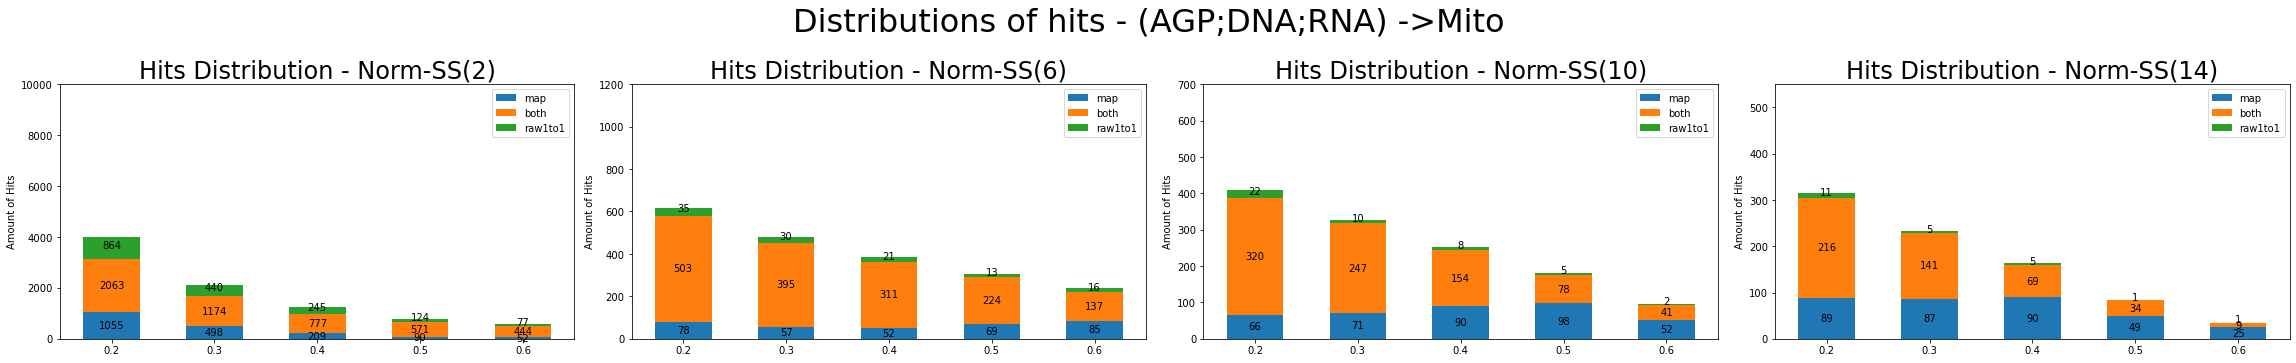

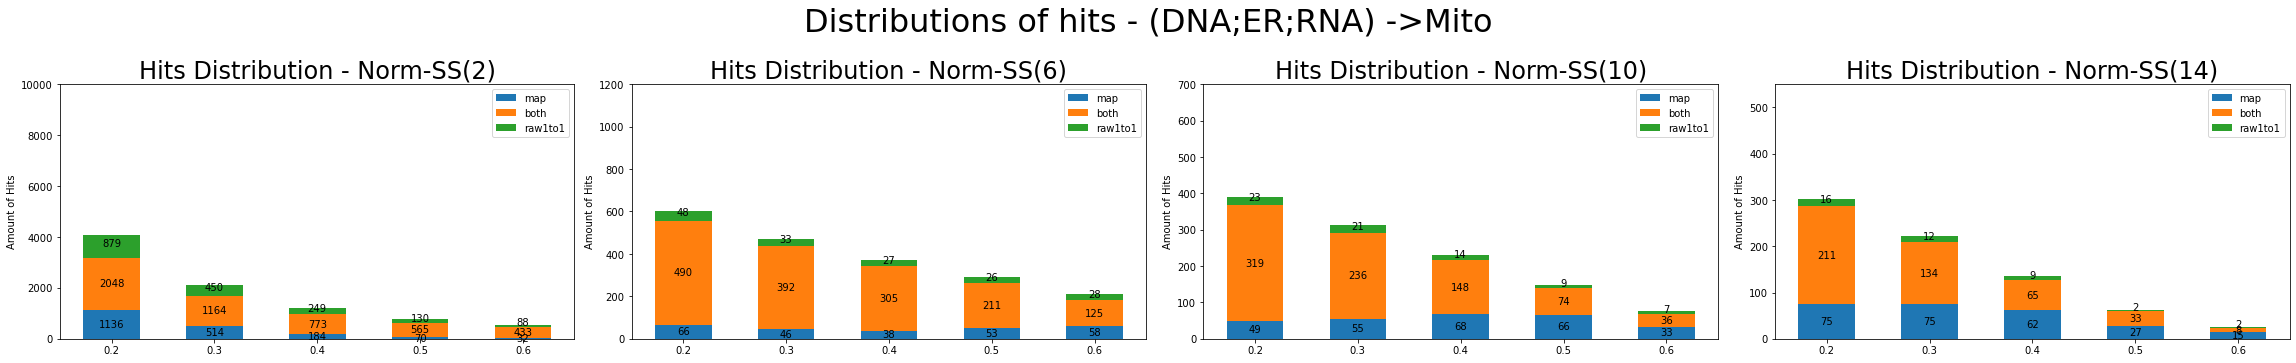

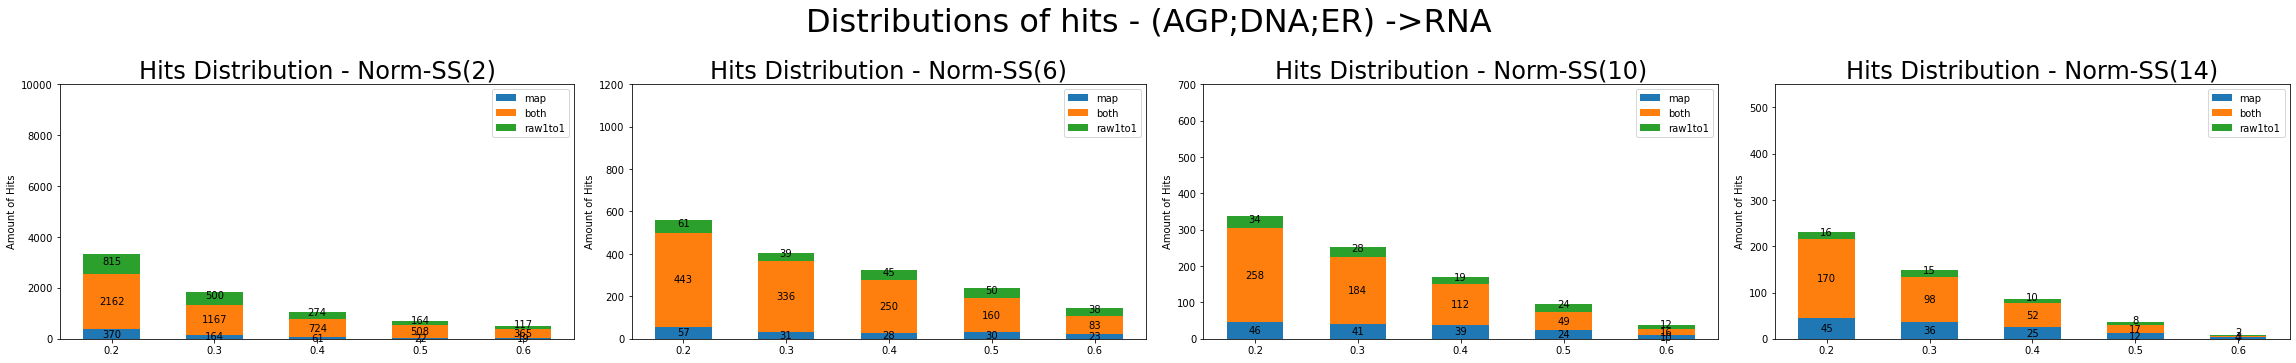

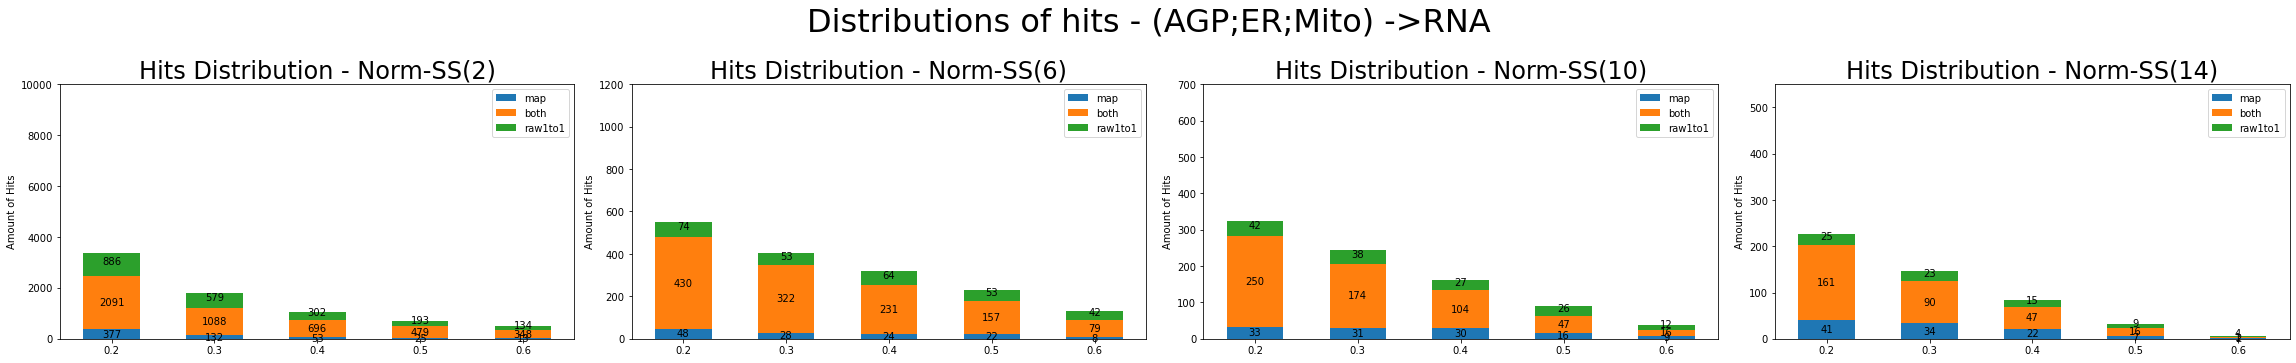

EmptyDataError: No columns to parse from file

In [73]:
chans = ['AGP', 'DNA', 'ER', 'Mito', 'RNA']

for i, chan in enumerate(chans):
    flds = glob(f'/storage/users/g-and-n/tabular_models_results/400*{i+1}/*/')
    other_chans = chans[:i] + chans[i + 1:]
    
    for cur_fld in flds:
        split_c = int(os.path.dirname(os.path.dirname(cur_fld))[-2]) - 1
        in_chans = list(list(combinations(other_chans, 3))[split_c])

        cur_df = pd.read_csv(f'{cur_fld}scores.csv', index_col=[0])

        res = cur_df.join(raw1to1.filter(like=chan, axis=1), how='left')
        plot_complementary(res, chan, title=';'.join(in_chans))

In [74]:
cur_fld

'/storage/users/g-and-n/tabular_models_results/40025/channel RNA/'